# **Ejercicios Unidad 1**


Alumno: Santiago Loza


# 1

Elija una de las imágenes color que tomó para la clase y aplique separación de canales y elija un método para transformarla en escala de grises. Muestre por pantalla los resultados obtenidos.

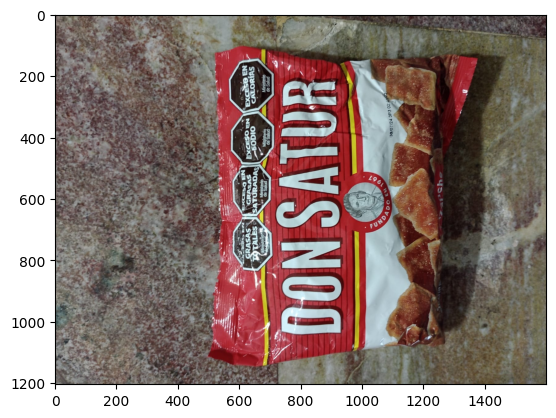

(<Figure size 640x480 with 1 Axes>,
 None)

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

imagen ='1.jpeg'

# --- Imagen RGB ------------------------------------------------------------------------
img = cv.imread(imagen)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(1), plt.imshow(img), plt.show(block=False)

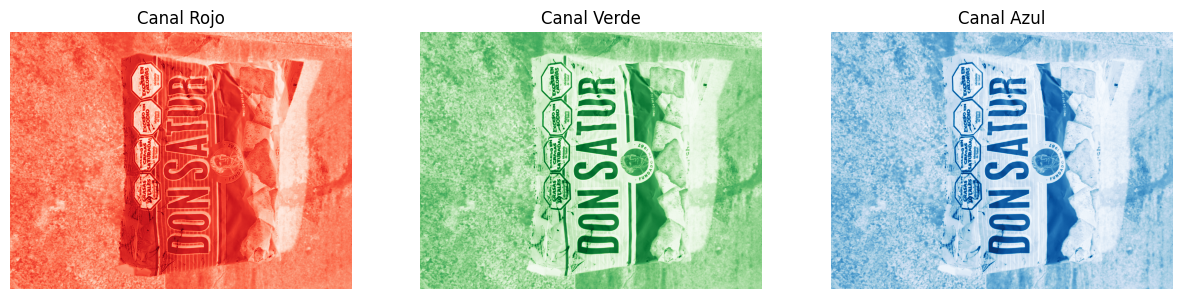

In [2]:
# Separar la imagen en los canales de color R, G, B
R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
# Paso 5: Mostrar cada canal de color
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(R, cmap='Reds')
axs[0].set_title('Canal Rojo')
axs[0].axis('off')

axs[1].imshow(G, cmap='Greens')
axs[1].set_title('Canal Verde')
axs[1].axis('off')

axs[2].imshow(B, cmap='Blues')
axs[2].set_title('Canal Azul')
axs[2].axis('off')

plt.show()

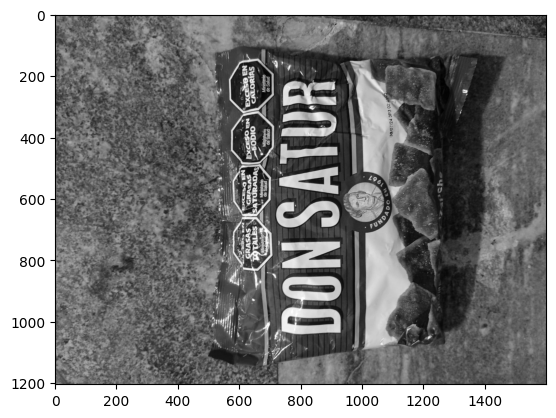

In [3]:
# Convertir la imagen a escala de grises
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray,cmap='gray')

# 2

Con las fotografías pedidas por la cátedra la clase pasada (la foto de objetos con fondo liso, y fotos del mismo producto en un contexto más complejo) usar los métodos de extracción de características (esos anteriores al Deep Learning) para encontrar la ubicación del producto dentro de la imagen.

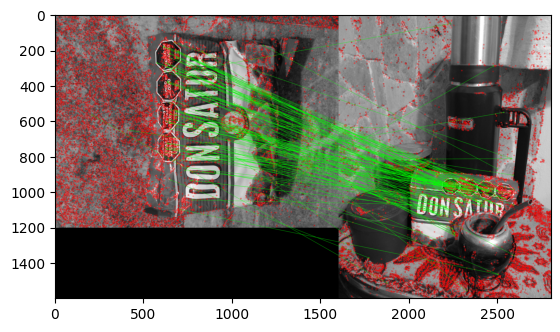

(<matplotlib.image.AxesImage at 0x7fbeb713dba0>, None)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar imágenes en escala de grises
img1 = cv.imread('1.jpeg', cv.IMREAD_GRAYSCALE)          # Imagen de consulta (queryImage)
img2 = cv.imread('2.jpeg', cv.IMREAD_GRAYSCALE)          # Imagen de entrenamiento (trainImage)

# Iniciar el detector SIFT
sift = cv.SIFT_create()

# Encontrar los keypoints y descriptores con SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Parámetros FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # o pasar un diccionario vacío

# Iniciar FLANN matcher
flann = cv.FlannBasedMatcher(index_params, search_params)

# Realizar emparejamientos kNN
matches = flann.knnMatch(des1, des2, k=2)

# Necesitamos dibujar solo los buenos emparejamientos, por lo que creamos una máscara
matchesMask = [[0, 0] for i in range(len(matches))]

# Test de proporción según el artículo de Lowe
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

# Parámetros de dibujo para los emparejamientos
draw_params = dict(matchColor=(0, 255, 0),  # color de los emparejamientos
                   singlePointColor=(255, 0, 0),  # color de los puntos individuales
                   matchesMask=matchesMask,  # máscara para seleccionar emparejamientos
                   flags=cv.DrawMatchesFlags_DEFAULT)

# Dibujar los emparejamientos kNN
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

# Mostrar la imagen resultante
plt.imshow(img3), plt.show()


# 4

Con los videos de [youtube.com](http://youtube.com) de cámara fija pedidos para esta clase, aplicar los algoritmos de detección de movimiento vistos en la teoría.


Probamos el video

In [ ]:
!pip install -q mediapy
import numpy as np
import mediapy as media
url = 'Video.mp4'
video = media.read_video(url)
media.show_video(video)

Preparamos nuestras funciones para reutilizar

In [6]:
# Función para oscurecer una imagen:
def process_image(new_image, prev_image, **kwargs):
    # Convertir la imagen a float32
    new_image_float = new_image.astype(np.float32)

    # Reducir el brillo de la imagen a la mitad
    new_image_float *= 0.5

    # Convertir la imagen de vuelta a uint8
    new_image_uint8 = np.clip(new_image_float, 0, 255).astype(np.uint8)

    return new_image_uint8

def draw_contours(frame, contours, color=(0, 255, 0), thickness=2):
    # Comprobar si la imagen es en escala de grises (1 canal)
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        # Convertir la imagen de escala de grises a color (3 canales)
        result_image = cv.cvtColor(frame, cv.COLOR_GRAY2BGR)
    else:
        # Si ya es una imagen de color, simplemente hacer una copia
        result_image = frame.copy()

    # Dibujar cada contorno en la imagen
    for contour in contours:
        # Obtener el rectángulo delimitador para cada contorno
        x, y, w, h = cv.boundingRect(contour)
        # Dibujar el rectángulo
        cv.rectangle(result_image, (x, y), (x + w, y + h), color, thickness)

    return result_image

# Función para procesar un video:
def video_processor(filename_in, filename_out, process_func, max_time=10, **kwargs):
    # Abrir el video de entrada para lectura
    with media.VideoReader(filename_in) as r:
        # Crear un archivo de video de salida
        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:
            count = 0  # Inicializar contador de fotogramas
            prev_image = None  # Inicializar la imagen previa

            # Iterar sobre cada imagen (fotograma) del video
            for image in r:
                new_image = media.to_uint8(image)  # Convertir la imagen a formato flotante

                # Comprobar si es la primera imagen
                if prev_image is None:
                    prev_image = new_image.copy()

                # Procesar la imagen utilizando la función dada
                processed_image = process_func(new_image, prev_image, **kwargs)

                # Añadir la imagen procesada al video de salida
                w.add_image(processed_image)

                # Actualizar la imagen previa
                prev_image = new_image.copy()

                # Incrementar el contador de fotogramas
                count += 1

                # Detener el proceso si se alcanza el tiempo máximo
                if count >= max_time * r.fps:
                    break




In [ ]:
# Nombres de los archivos de video de entrada y salida
filename_in = url
filename_out = 'Video_dark.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_image, 10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

Frame Difference (Sustracción de frames)

In [ ]:
# Función actualizada para realizar diferencia de fotogramas con normalización:
def process_frame_difference(new_image, prev_image, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv.cvtColor(new_image, cv.COLOR_RGB2GRAY)
    prev_gray = cv.cvtColor(prev_image, cv.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv.normalize(frame_diff, None, 0, 255, cv.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv.threshold(norm_diff, 30, 255, cv.THRESH_BINARY)

    # Convertir la imagen umbralizada a color para mantener la consistencia con el video original
    thresh_color = cv.cvtColor(thresh, cv.COLOR_GRAY2RGB)

    return thresh_color

# Nombres de los archivos de video de entrada y salida
filename_in = url
filename_out = 'Video_frame_difference.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_frame_difference, 10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

In [ ]:
# Función actualizada para detectar movimientos y dibujar cuadros delimitadores:
def process_frame_difference_full(new_image, prev_image, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv.cvtColor(new_image, cv.COLOR_RGB2GRAY)
    prev_gray = cv.cvtColor(prev_image, cv.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv.normalize(frame_diff, None, 0, 255, cv.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv.threshold(norm_diff, 30, 255, cv.THRESH_BINARY)

    # Dilatar la imagen umbralizada para mejorar la detección de contornos
    kernel = np.ones((5,5),np.uint8)
    dilated = cv.dilate(thresh, kernel, iterations = 1)

    # Convertir la imagen dilatada a formato adecuado para findContours
    dilated = dilated.astype(np.uint8)

    # Encontrar contornos en la imagen dilatada
    contours, _ = cv.findContours(dilated, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Dibujar cuadros delimitadores alrededor de los contornos
    if kwargs.get('draw_mode', 0) == 0:
      result_image = draw_contours(new_image, contours)
    elif kwargs.get('draw_mode', 0) == 1:
      result_image = draw_contours(thresh, contours)

    return result_image


# Nombres de los archivos de video de entrada y salida
filename_in = url
filename_out = 'Video_frame_difference_full.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_frame_difference_full,
                max_time=10, draw_mode=1)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

# Llamar a la función para procesar el video
filename_out = 'Video_frame_difference_full_2.mp4'
video_processor(filename_in, filename_out, process_frame_difference_full,
                max_time=10, draw_mode=0)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

Optical Flow

Optical Flow - Sparse

In [ ]:
def process_sparse_optical_flow(new_image, prev_image):
    # Preparamos las imagenes de trabajo
    new_gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)
    prev_gray_image = cv.cvtColor(prev_image, cv.COLOR_BGR2GRAY)

    # Verificar si ya se han detectado las características de Shi-Tomasi
    if not hasattr(process_sparse_optical_flow, "shi_tomasi_done"):
        # Definir parámetros para la detección de esquinas de Shi-Tomasi
        feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
        # Detectar puntos característicos en la imagen
        process_sparse_optical_flow.prev_points = cv.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
        # Crear una máscara para dibujar el flujo óptico
        process_sparse_optical_flow.mask = np.zeros_like(new_image)
        # Marcar que se ha completado la detección de Shi-Tomasi
        process_sparse_optical_flow.shi_tomasi_done = True

    # Continuar si se ha completado la detección de Shi-Tomasi
    if process_sparse_optical_flow.shi_tomasi_done:
        prev_points = process_sparse_optical_flow.prev_points
        mask = process_sparse_optical_flow.mask

    # Parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # Calcular el flujo óptico de Lucas-Kanade
    new_points, status, error = cv.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # Filtrar puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # Color para el dibujo
    # Dibujar el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv.line(mask, (a, b), (c, d), color, 2)
        new_image = cv.circle(new_image, (a, b), 3, color, -1)

    # Combinar la imagen actual con las líneas de flujo óptico dibujadas
    output = cv.add(new_image, mask)
    # Actualizar puntos para el siguiente cuadro
    process_sparse_optical_flow.prev_points = good_new.reshape(-1, 1, 2)
    return output

# Nombres de los archivos de video de entrada y salida
filename_in = url
filename_out = 'Video_process_sparse_optical_flow.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_sparse_optical_flow,
                max_time=10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

Optical Flow - Dense

In [ ]:
# Función para procesar el flujo óptico denso
def process_dense_optical_flow(new_image, prev_image):
    # Convierte la nueva imagen a escala de grises
    gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)

    if not hasattr(process_dense_optical_flow, "init_done"):
        process_dense_optical_flow.prev_gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)
        process_dense_optical_flow.mask = np.zeros_like(new_image)
        process_dense_optical_flow.mask[..., 1] = 255
        process_dense_optical_flow.init_done = True

    if process_dense_optical_flow.init_done:
        prev_gray = process_dense_optical_flow.prev_gray
        mask = process_dense_optical_flow.mask

    # Calcula el flujo óptico
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computa magnitud y ángulo de los vectores 2D
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    # Establece el tono de la imagen según la dirección del flujo óptico
    mask[..., 0] = angle * 180 / np.pi / 2
    # Establece el valor de la imagen según la magnitud del flujo óptico
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    # Convierte de HSV a RGB
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    # Actualiza la imagen previa a gris
    process_dense_optical_flow.prev_grayprev_gray = gray.copy()
    return rgb

# Nombres de los archivos de video de entrada y salida
filename_in = url
filename_out = 'Video_process_dense_optical_flow.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_dense_optical_flow,
                max_time=20)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

Background Subtraction

Prueba de varios modelos disponibles en OpenCV

In [ ]:
def process_back_sub(new_image, prev_image, **kwargs):
  # Inicializar el sustractor de fondo si aún no se ha hecho
  if not hasattr(process_back_sub, 'init_done'):
    # Obtener el método de sustracción de fondo especificado
    method = kwargs.get('method', 'MOG')
    match method:
      case 'CNT':
          process_back_sub.back_method = cv.bgsegm.createBackgroundSubtractorCNT()
      case 'GMG':
          process_back_sub.back_method = cv.bgsegm.createBackgroundSubtractorGMG()
      case 'GSOC':
          process_back_sub.back_method = cv.bgsegm.createBackgroundSubtractorGSOC()
      case 'LSBP':
          process_back_sub.back_method = cv.bgsegm.createBackgroundSubtractorLSBP()
      case 'KNN':
          process_back_sub.back_method = cv.createBackgroundSubtractorKNN()
      case 'MOG' | 'MOG2':
          process_back_sub.back_method = cv.createBackgroundSubtractorMOG2(detectShadows=kwargs.get('detect_shadows', True))
      case _:
          print(f'Método {method} no implementado')
    process_back_sub.init_done = True

  # Aplicar el método de sustracción de fondo seleccionado a la nueva imagen
  back_method = process_back_sub.back_method
  foreground_mask = back_method.apply(new_image)

  # Umbralizar la máscara para resaltar los objetos en movimiento
  _, thresh = cv.threshold(foreground_mask, kwargs.get('threshold_val', 30), 255, cv.THRESH_BINARY)

  # Aplicar erosión y dilatación para mejorar la segmentación
  kernel_size = kwargs.get('kernel_size', 5)
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  thresh = cv.erode(thresh, kernel, iterations=kwargs.get('erode_iterations', 1))
  thresh = cv.dilate(thresh, kernel, iterations=kwargs.get('dilate_iterations', 1))

  # Encontrar contornos
  contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  # Determinar qué imagen se usará para dibujar los contornos
  match result_frame:
    case 'mask':
        result_image = cv.cvtColor(foreground_mask, cv.COLOR_GRAY2BGR)
    case 'morph':
        result_image = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)
    case _:  # original
      result_image = new_image

  # Dibujar cuadros delimitadores (bounding boxes)
  show_boxes = kwargs.get('show_boxes', True)
  if show_boxes:
    for contour in contours:
        if cv.contourArea(contour) > kwargs.get('min_area', 100):
            x, y, w, h = cv.boundingRect(contour)
            result_image = cv.rectangle(result_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

  return result_image

# Nombres de los archivos de video de entrada y salida
filename_in = url
result_frame = 'morph'   # Opciones: 'mask', 'morph', 'original'
for method in ['MOG', 'CNT', 'GMG', 'GSOC', 'LSBP', 'KNN']:
  filename_out = f'highway_background_subtraction_{method}.mp4'

  # Llamar a la función para procesar el video
  video_processor(filename_in, filename_out, process_back_sub,
                  max_time=10, method=method, result_frame=result_frame)

  # Mostrar el video resultante
  print(f'Método {method}:')
  media.show_video(media.read_video(filename_out), fps=30)


# 5


(Entrega obligatoria individual en repo) Genere un video en un patio o en un hall de edificio donde en un principio se vea vacío y luego aparezca una persona. Mediante los métodos de motion detection (sin usar deep learning) logre una detección de la persona cuando entra al cuadro suponiendo la utilidad para una cámara de seguridad.
Luego sobre el mismo video aplique los algoritmos de flujo denso y disperso que se mostraron en clase.
Escriba una reflexión sobre los resultados en el formato md dentro del Jupyter Notebook.

In [13]:
filename_in_ej5 = 'Video_patio.mp4'

In [ ]:
# Función actualizada para detectar movimientos y dibujar cuadros delimitadores:
def process_frame_difference_full(new_image, prev_image, min_area_threshold=22000, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv.cvtColor(new_image, cv.COLOR_RGB2GRAY)
    prev_gray = cv.cvtColor(prev_image, cv.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv.normalize(frame_diff, None, 0, 255, cv.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv.threshold(norm_diff, 45, 255, cv.THRESH_BINARY)

    # Dilatar la imagen umbralizada para mejorar la detección de contornos
    kernel = np.ones((6,6),np.uint8)
    dilated = cv.dilate(thresh, kernel, iterations = 1)

    # Convertir la imagen dilatada a formato adecuado para findContours
    dilated = dilated.astype(np.uint8)

    # Encontrar contornos en la imagen dilatada
    contours, _ = cv.findContours(dilated, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Filtramos contornos basándonos en el área mínima
    large_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area_threshold]

    # Dibujar cuadros delimitadores alrededor de los contornos
    if kwargs.get('draw_mode', 0) == 0:
      result_image = draw_contours(new_image, large_contours)
    elif kwargs.get('draw_mode', 0) == 1:
      result_image = draw_contours(thresh, large_contours)

    return result_image



# Nombres de los archivos de video de entrada y salida
filename_in = filename_in_ej5
filename_out = 'Video_patio_frame_difference_full.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_frame_difference_full,
                max_time=10, draw_mode=1)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

# Llamar a la función para procesar el video
filename_out = 'Video_patio_frame_difference_full_2.mp4'
video_processor(filename_in, filename_out, process_frame_difference_full,
                max_time=10, draw_mode=0)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

**Optical Flow - Sparse**

In [ ]:
import mediapy

def process_sparse_optical_flow(new_image, prev_image):
    # Preparamos las imagenes de trabajo
    new_gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)
    prev_gray_image = cv.cvtColor(prev_image, cv.COLOR_BGR2GRAY)

    # Verificar si ya se han detectado las características de Shi-Tomasi
    if not hasattr(process_sparse_optical_flow, "shi_tomasi_done"):
        # Definir parámetros para la detección de esquinas de Shi-Tomasi
        feature_params = dict(maxCorners=300, qualityLevel=0.1, minDistance=1.5, blockSize=2)
        # Detectar puntos característicos en la imagen
        process_sparse_optical_flow.prev_points = cv.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
        # Crear una máscara para dibujar el flujo óptico
        process_sparse_optical_flow.mask = np.zeros_like(new_image)
        # Marcar que se ha completado la detección de Shi-Tomasi
        process_sparse_optical_flow.shi_tomasi_done = True

    # Continuar si se ha completado la detección de Shi-Tomasi
    if process_sparse_optical_flow.shi_tomasi_done:
        prev_points = process_sparse_optical_flow.prev_points
        mask = process_sparse_optical_flow.mask

    # Parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # Calcular el flujo óptico de Lucas-Kanade
    new_points, status, error = cv.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # Filtrar puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # Color para el dibujo
    # Dibujar el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv.line(mask, (a, b), (c, d), color, 2)
        new_image = cv.circle(new_image, (a, b), 3, color, -1)

    # Combinar la imagen actual con las líneas de flujo óptico dibujadas
    output = cv.add(new_image, mask)
    # Actualizar puntos para el siguiente cuadro
    process_sparse_optical_flow.prev_points = good_new.reshape(-1, 1, 2)
    return output

# Nombres de los archivos de video de entrada y salida
filename_in = filename_in_ej5
filename_out = 'video_patio_sparse_optical_flow.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_sparse_optical_flow,
                max_time=10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

**Optical Flow - Dense**

In [ ]:
# Función para procesar el flujo óptico denso
def process_dense_optical_flow(new_image, prev_image):
    # Convierte la nueva imagen a escala de grises
    gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)

    if not hasattr(process_dense_optical_flow, "init_done"):
        process_dense_optical_flow.prev_gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)
        process_dense_optical_flow.mask = np.zeros_like(new_image)
        process_dense_optical_flow.mask[..., 1] = 255
        process_dense_optical_flow.init_done = True

    if process_dense_optical_flow.init_done:
        prev_gray = process_dense_optical_flow.prev_gray
        mask = process_dense_optical_flow.mask

    # Calcula el flujo óptico
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computa magnitud y ángulo de los vectores 2D
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    # Establece el tono de la imagen según la dirección del flujo óptico
    mask[..., 0] = angle * 180 / np.pi / 2
    # Establece el valor de la imagen según la magnitud del flujo óptico
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    # Convierte de HSV a RGB
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    # Actualiza la imagen previa a gris
    process_dense_optical_flow.prev_grayprev_gray = gray.copy()
    return rgb

# Nombres de los archivos de video de entrada y salida
filename_in = filename_in_ej5
filename_out = 'Video_patio_process_dense_optical_flow.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_dense_optical_flow,
                max_time=20)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)


**Metodos de detección de movimiento**

Cuando probamos los algoritmos, vimos que funcionaban bien para detectar cuando una persona entraba en el video. Lo que llamó mi atención fue, que cuando no habia ninguna persona en el video se detectaba ruido en el fondo, haciendo que se dibujen pequeños rectangulos en el video como si se detectara un objeto. Este problema lo pude solucionar con un umbral de area mínima, el cuál, filtrará objetos según su área para detectar.

Esto nos hizo pensar que los algoritmos pueden ser muy sensibles y detectar cosas que no son realmente importantes.

**Algoritmo de flujo óptico denso**


Al probar el algoritmo de flujo óptico denso en el video, notamos un comportamiento interesante. El algoritmo fue capaz de detectar puntos en el fondo, como los del aire acondicionado, y luego se enfocó en los puntos de la parte superior de la persona, detectando el movimiento de los mismos.

**Algoritmo de flujo óptico disperso**


Cuando probamos el algoritmo de flujo óptico disperso, funcionó bien para detectar a una persona en movimiento. Notamos que detecta los objetos del fondo, tanto los cercanos, como los mas lejanos.

A pesar de esto, el algoritmo sigue siendo útil para encontrar a personas en movimiento de manera eficiente. Pero necesitamos trabajar en cómo evitar que detecte cosas irrelevantes cuando no hay nadie en la escena.



# 6

(Entrega obligatoria individual en repo) Explique cuál es diferencia entre localización de objetos y clasificación de imágenes. Muestre ejemplos de ello.

La **clasificación de imágenes** implica la capacidad de identificar el contenido general de una imagen, como distinguir si una foto muestra un perro o un gato.

Por otro lado, cuando se trata de imágenes con múltiples objetos, la **localización de objetos** entra en juego. Esta tarea implica la identificación y localización precisa de cada objeto dentro de la imagen. Esto se logra delimitando cada objeto con cajas rectangulares, lo que ayuda a la máquina a reconocer y etiquetar correctamente cada objeto. Además, estas cajas proporcionan información sobre la ubicación exacta de los objetos en la imagen.

Por ejemplo:
En la siguiente imagen veremos ambas aplicaciones. Por un lado podemos ver que se utiliza **localización de objetos** para localizar los distintos objetos que aparecen en la imagen, y por otro lado, podemos observar que se utilizar **clasificación de imagenes** para clasificar a las distintas imagenes.


En la siguiente imagen, se ilustran ambas aplicaciones: la **localización de objetos** y la clasificación de imágenes. Por un lado, se utiliza la localización de objetos para identificar y delimitar cada objeto individual presente en la imagen, como las sillas y el termo, mediante el trazado de cajas delimitadoras alrededor de ellos. Por otro lado, se aplica la **clasificación de imágenes** para categorizar los distintos objetos representadas en la imagen, como las sillas y la mesa donde se encuentra apoyado el equipo de mate. Estas dos técnicas trabajan en conjunto para proporcionar una comprensión completa del contenido visual de la imagen.

In [17]:
%pip install ultralytics
# Librería mediapy para mostrar videos
%pip install -q mediapy
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/78.2 GB disk)



0: 640x512 1 bottle, 2 cups, 3 chairs, 2 dining tables, 13.5ms
Speed: 4.2ms preprocess, 13.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 512)


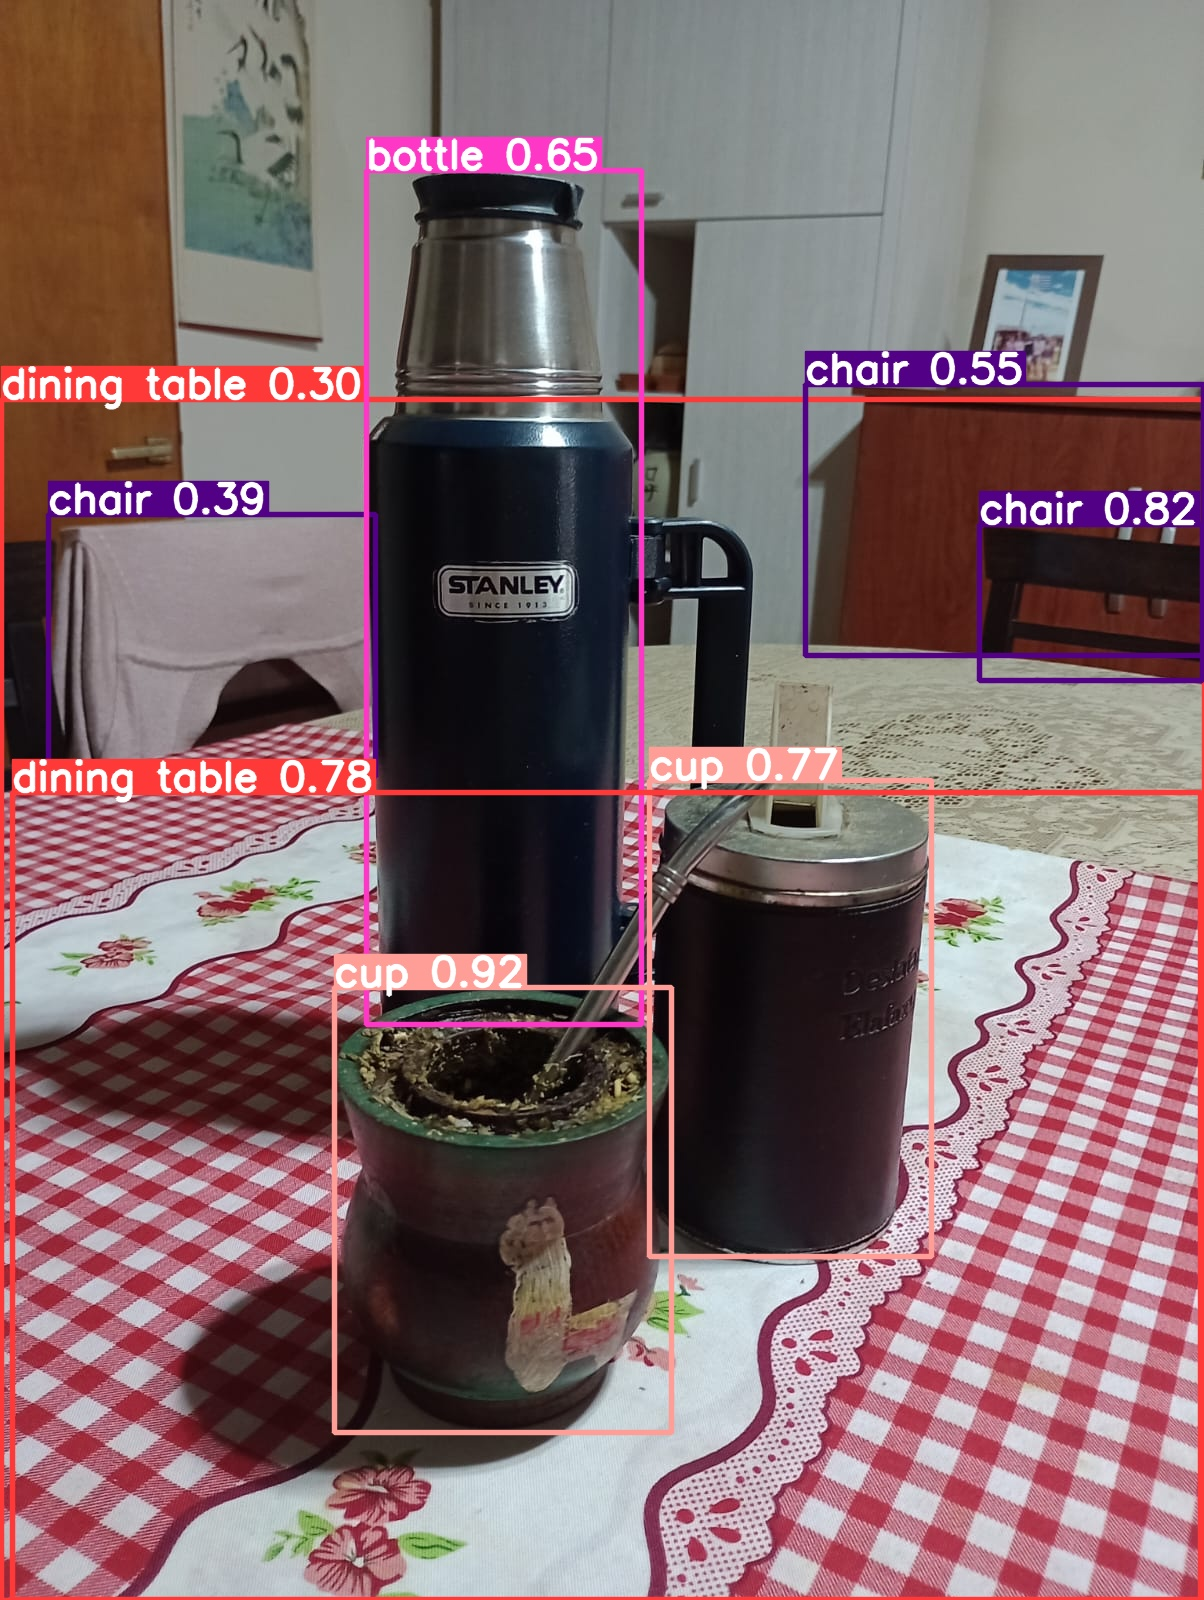

In [21]:
# Importamos las librerías a utilizar
from ultralytics import YOLO
from IPython.display import Image

# Load the pre-trained YOLOv8 model
model = YOLO('yolov8n')  #

# Perform inference
source_img = cv.imread('mate.jpeg')
results = model(source_img)

# Visualize the results on the frame
annotated_frame = results[0].plot()

# Guardamos el resultado en JPG
cv.imwrite('resultado_mate.jpg', annotated_frame)

# Mostramos el resultado en Colab
Image('resultado_mate.jpg')